# Advanced Computer Vision

In [ ]:
# 1.1 Human Detection
!pip install fiftyone # For COCO Persons
!git clone https://github.com/SkalskiP/yolov9.git
!pip install ultralytics
# !pip install yolov9
# Using: https://mkadric.medium.com/how-to-use-yolo-object-detection-model-1604cf9bbaed
# and https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov9-object-detection-on-custom-dataset.ipynb#scrollTo=qggEg7Hv1zJ6
# and https://medium.com/@Mert.A/how-to-use-yolov9-for-object-detection-93598ad88d7d

# 1.3 Diversity Classification
# CIFAR-100
!pip install vit-pytorch # Vision Transformer https://github.com/lucidrains/vit-pytorch?tab=readme-ov-file#resources
# Using: Practical Image_Classification_Alex_GPU.ipynb and https://github.com/lucidrains/vit-pytorch/blob/main/examples/cats_and_dogs.ipynb for classification

# 2 StyleTransfer
# CycleGAN https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/data/template_dataset.py
!pip install dominate
!pip install lpips
# Using: the CycleGAN GitHub above

# Other
!pip install opencv-python-headless
!pip install moviepy
!pip install Pillow


In [ ]:
import os
import cv2
import numpy as np

import fiftyone
import fiftyone.zoo

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import CIFAR100

from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt

from vit_pytorch.cvt import CvT
from vit_pytorch import SimpleViT

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import time

from PIL import Image
from IPython.display import Image

from ultralytics import YOLO

import subprocess

import random
from natsort import natsorted

from moviepy.editor import VideoFileClip

import json
import glob
import shutil
import lpips
import csv

from google.colab import files, drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# fileupload = files.upload()
# filename = next(iter(fileupload))
# print(filename)

# files.download(filename)

# !zip -r ./CompressedFiles1.zip ./sample_data/
# files.download("CompressedFiles1.zip")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.1.1 Define Human Detection Model (COCO and YOLOv9)

In [ ]:
# Load the COCO Person dataset for train
train_human = fiftyone.zoo.load_zoo_dataset(
  "coco-2017",
  split="train",
  label_types=["detections"],
  classes=["person"],
  max_samples=1000,
  dataset_name="coco-2017-train-person"
)

# Load the COCO Person dataset for validation
val_human = fiftyone.zoo.load_zoo_dataset(
  "coco-2017",
  split="validation",
  label_types=["detections"],
  classes=["person"],
  max_samples=200,
  dataset_name="coco-2017-val-person"
)

export_dir = "/content/drive/MyDrive/Computer Vision/Data/Detection"

splits = ["train", "val"]
classes = ["person"]

# Export the dataset
datasets = {"train": train_human, "val": val_human}
for split, dataset in datasets.items():
  dataset.export(
    export_dir=f"{export_dir}/{split}",
    dataset_type=fiftyone.types.YOLOv5Dataset,
    label_field="ground_truth",
    classes=classes
  )

In [ ]:
# Visualize a small sample of the dataset
# session = fiftyone.launch_app(train_human)

sample = train_human.first()
print(sample)

detections = sample["ground_truth"].detections

for detection in detections:
  print(f"Label: {detection.label}, BBox: {detection.bounding_box}")

<Sample: {
    'id': '6631920638eb3e2a30d4bad5',
    'media_type': 'image',
    'filepath': '/root/fiftyone/coco-2017/train/data/000000000036.jpg',
    'tags': ['train'],
    'metadata': <ImageMetadata: {
        'size_bytes': None,
        'mime_type': None,
        'width': 481,
        'height': 640,
        'num_channels': None,
    }>,
    'ground_truth': <Detections: {
        'detections': [
            <Detection: {
                'id': '6631920638eb3e2a30d4bad3',
                'attributes': {},
                'tags': [],
                'label': 'umbrella',
                'bounding_box': [0.0, 0.0783125, 0.9515176715176715, 0.6724218750000001],
                'mask': None,
                'confidence': None,
                'index': None,
                'supercategory': 'accessory',
                'iscrowd': 0,
            }>,
            <Detection: {
                'id': '6631920638eb3e2a30d4bad4',
                'attributes': {},
                'tags': [],
      

In [ ]:
# Train with YOLO-v9 model
!git clone https://github.com/WongKinYiu/yolov9
%cd yolov9
!pip install -r requirements.txt -q

# !wget -P /content/drive/MyDrive/Computer\ Vision/Data/Detection/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
# !wget -P /content/drive/MyDrive/Computer\ Vision/Data/Detection/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
# !wget -P /content/drive/MyDrive/Computer\ Vision/Data/Detection/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
# !wget -P /content/drive/MyDrive/Computer\ Vision/Data/Detection/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

Cloning into 'yolov9'...
remote: Enumerating objects: 668, done.
remote: Counting objects: 100% (290/290), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 668 (delta 222), reused 199 (delta 199), pack-reused 378
Receiving objects: 100% (668/668), 3.22 MiB | 28.45 MiB/s, done.
Resolving deltas: 100% (269/269), done.
/content/yolov9/yolov9


In [ ]:
# Define the training code
!python train.py \
  --batch 16 \
  --epochs 25 \
  --imgsz 640 \
  --device 0 \
  --data /content/drive/MyDrive/Computer\ Vision/Data/Detection/train/dataset.yaml \
  --weights /content/drive/MyDrive/Computer\ Vision/Data/Detection/weights/gelan-c.pt \
  --cfg /content/yolov9/models/detect/gelan-c.yaml \
  --hyp /content/yolov9/data/hyps/hyp.scratch-high.yaml

2024-05-01 01:26:16.742510: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 01:26:16.742567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 01:26:16.744427: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-01 01:26:17.798531: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=/content/drive/MyDrive/Computer Vision/Data/Detection/weights/gelan-c.pt, cfg=/content/yolov9/models/detect/gelan-c.yaml, data=/content/drive/MyDrive/Computer Vision/Data/Detection/train/dataset.yaml, hyp=/content/yolov9/data/

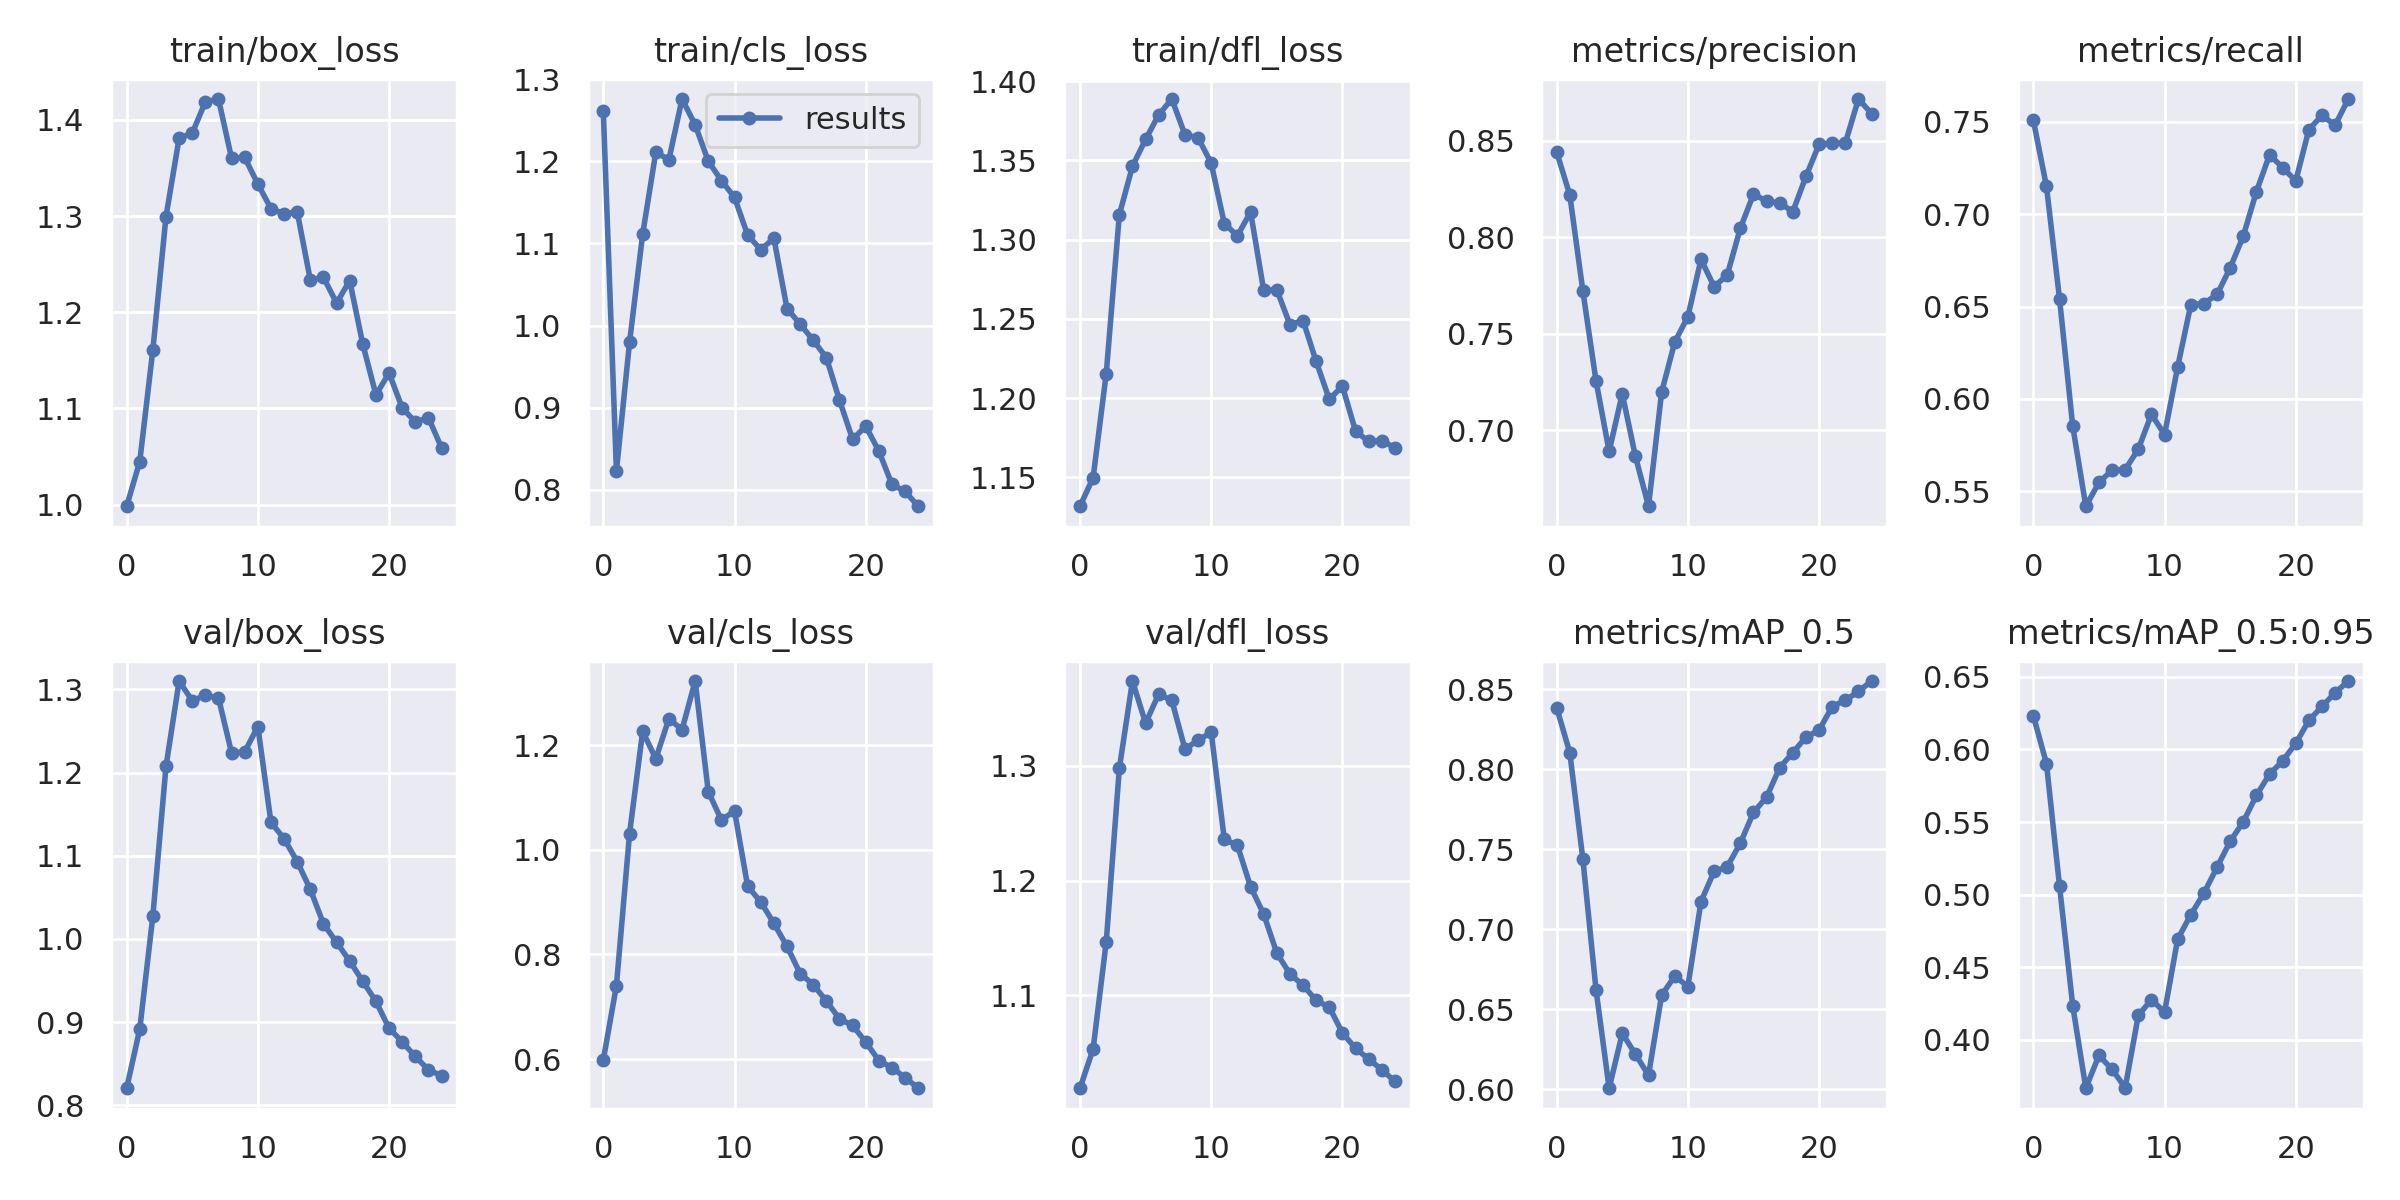

In [ ]:
# Evaluation
# !ls /content/yolov9/yolov9/runs/train/exp/
# !mv /content/yolov9/yolov9/runs/train/exp/ /content/drive/MyDrive/Computer\ Vision/Data/Detection/evaluation_results

# See the confusion matrix
Image(filename=f"/content/drive/MyDrive/Computer Vision/Data/Detection/evaluation_results/exp/confusion_matrix.png", width=1000)

# See the large array of results
Image(filename=f"/content/drive/MyDrive/Computer Vision/Data/Detection/evaluation_results/exp/results.png", width=1000)

## 1.1.2 Run the Human Detection Model

In [ ]:
# Define the model
# model = YOLO("/content/drive/MyDrive/Computer Vision/Data/Detection/weights/gelan-c.pt")
# model = torch.hub.load('WongKinYiu/yolov9', 'custom', path="/content/drive/MyDrive/Computer Vision/Data/Detection/weights/gelan-c.pt", force_reload=True)

# Load the state dictionary
# model.load_state_dict(torch.load('/content/drive/MyDrive/Computer Vision/Data/Detection/weights/gelan-c.pt'))
# model.eval()

In [ ]:
# Find all the training mp4 files
train_dir = "/content/drive/MyDrive/Computer Vision/Data/Train"

mp4_files = []

# Loop through the files to find the mp4 files
for path, folders, files in os.walk(train_dir):
  for filename in [f for f in files if f.endswith(".mp4")]:
    mp4_files.append(os.path.join(path, filename))

print(mp4_files)

['/content/drive/MyDrive/Computer Vision/Data/Train/game/MafiaVideogame.mp4', '/content/drive/MyDrive/Computer Vision/Data/Train/movie/TheGodfather.mp4', '/content/drive/MyDrive/Computer Vision/Data/Train/movie/TheIrishman.mp4', '/content/drive/MyDrive/Computer Vision/Data/Train/movie/TheSopranos.mp4']


In [ ]:
# Define the necessary function to process each frame
# def detect_people(frame, model):
#   (H, W) = frame.shape[:2]
#   # blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB=True, crop=False)
#   # net.setInput(blob)
#   # layer_names = net.getUnconnectedOutLayersNames()
#   # layer_outputs = net.forward(layer_names)

#   blob = torch.from_numpy(frame).permute(2, 0, 1).float().div(255.0).unsqueeze(0)
#   blob = blob.to('cuda' if torch.cuda.is_available() else 'cpu')

#   with torch.no_grad():
#     outputs = model(blob)

#   people = []

#   for detection in outputs[0]:
#     scores = detection[5:]
#     class_id = torch.argmax(scores)
#     confidence = scores[class_id]
#     if class_id == 0 and confidence > 0.5:
#         box = detection[:4] * torch.tensor([W, H, W, H])
#         (centerX, centerY, width, height) = box.int()
#         x = int(centerX - (width / 2))
#         y = int(centerY - (height / 2))
#         people.append((x, y, width.item(), height.item()))

#   # for output in layer_outputs:
#   #   for detection in output:
#   #     scores = detection[5:]
#   #     class_id = np.argmax(scores)
#   #     confidence = scores[class_id]
#   #     if class_id == 0 and confidence > 0.5:
#   #       box = detection[0:4] * np.array([W, H, W, H])
#   #       (centerX, centerY, width, height) = box.astype("int")
#   #       x = int(centerX - (width / 2))
#   #       y = int(centerY - (height / 2))
#   #       people.append((x, y, int(width), int(height)))

#   return people

# Detect people within each frame
def detect_people(frame, W, H):
  people = []
  model_path = "/content/drive/MyDrive/Computer Vision/Data/Detection/weights/gelan-c.pt"
  conf = 0.5

  frame_path = "/tmp/frame.jpg"
  cv2.imwrite(frame_path, frame)

  output_dir = "/content/drive/MyDrive/Computer Vision/Data/Detection/runs/detect"
  output_name = "static_exp"

  # Run the model to make the detection prediction
  command = f"python yolov9/detect.py --weights \"{model_path}\" --conf-thres {conf} --source \"{frame_path}\" --device 0 --save-txt --save-conf --project \"{output_dir}\" --name \"{output_name}\" --exist-ok"

  # Delete existing labels within our folder for the previous frame
  list_of_dirs = glob.glob(f'{output_dir}/{output_name}*')
  if list_of_dirs:
    latest_dir = max(list_of_dirs, key=os.path.getctime)
    label_file = os.path.join(latest_dir, 'labels', os.path.basename(frame_path).replace('.jpg', '.txt'))
    if os.path.exists(label_file):
      os.remove(label_file)
      print(f"Deleted existing label file: {label_file}")

  process = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
  if process.returncode != 0:
    print("Error:", process.stderr)
    return []

  # Check the directory for the txt file
  list_of_dirs = glob.glob(f'{output_dir}/{output_name}*')
  latest_dir = max(list_of_dirs, key=os.path.getctime)
  label_file = os.path.join(latest_dir, 'labels', os.path.basename(frame_path).replace('.jpg', '.txt'))

  # Read the txt file correctly
  if os.path.exists(label_file):
    with open(label_file, 'r') as file:
      lines = file.readlines()
      for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        # Extract the patches
        # Make sure these are the best (above 82% confidence)
        if class_id == 0 and float(parts[5]) >= 0.82:
          x_center = float(parts[1]) * W
          y_center = float(parts[2]) * H
          width = float(parts[3]) * W
          height = float(parts[4]) * H
          x1 = int(x_center - (width / 2))
          y1 = int(y_center - (height / 2))
          x2 = int(x_center + (width / 2))
          y2 = int(y_center + (height / 2))
          people.append((x1, y1, x2, y2))
  else:
    print("Detection results file not found:", label_file)

  # print(people)

  return people


# Define the frame interval to check (for variety)
interval = 640
image_counter = 0

game_patch_dir = "/content/drive/MyDrive/Computer Vision/Data/Patches/game"
movie_patch_dir = "/content/drive/MyDrive/Computer Vision/Data/Patches/movie"

# Loop through each mp4 training file
for video_file in mp4_files:
  cap = cv2.VideoCapture(video_file)
  frame_count = 0
  # processed_frames = 0

  while True:
    ret, frame = cap.read()
    if not ret:
      break

    H, W = frame.shape[:2]

    # Categorise the frames based on game/movie
    category = "game" if "game" in video_file else "movie"

    # Extract the frames at certain intervals
    if frame_count % interval == 0:
      detections = detect_people(frame, W, H)
      # in_frame = np.array(frame)
      # frame_filename = f"{video_file}_frame_{frame_count}.jpg"
      # cv2.imwrite(frame_filename, in_frame)
      # processed_frames += 1
      # Loop through the detections and store the correct bounds
      for (x1, y1, x2, y2) in detections:
        x1, y1, x2, y2 = max(0, x1), max(0, y1), min(W, x2), min(H, y2)
        human_patch = frame[y1:y2, x1:x2]
        if category == "game":
          patch_filename = os.path.join(game_patch_dir, f"{image_counter}.jpg")
        else:
          patch_filename = os.path.join(movie_patch_dir, f"{image_counter}.jpg")
        # Correctly save the patch
        cv2.imwrite(patch_filename, human_patch)
        image_counter += 1

    frame_count += 1

  cap.release()

Deleted existing label file: /content/drive/MyDrive/Computer Vision/Data/Detection/runs/detect/static_exp/labels/frame.txt
Detection results file not found: /content/drive/MyDrive/Computer Vision/Data/Detection/runs/detect/static_exp/labels/frame.txt
Detection results file not found: /content/drive/MyDrive/Computer Vision/Data/Detection/runs/detect/static_exp/labels/frame.txt
Detection results file not found: /content/drive/MyDrive/Computer Vision/Data/Detection/runs/detect/static_exp/labels/frame.txt
Detection results file not found: /content/drive/MyDrive/Computer Vision/Data/Detection/runs/detect/static_exp/labels/frame.txt
Deleted existing label file: /content/drive/MyDrive/Computer Vision/Data/Detection/runs/detect/static_exp/labels/frame.txt
Deleted existing label file: /content/drive/MyDrive/Computer Vision/Data/Detection/runs/detect/static_exp/labels/frame.txt
Detection results file not found: /content/drive/MyDrive/Computer Vision/Data/Detection/runs/detect/static_exp/labels/f

In [ ]:
# Save 50 images in another folder
source_dirs = [
  "/content/drive/MyDrive/Computer Vision/Data/Patches/game",
  "/content/drive/MyDrive/Computer Vision/Data/Patches/movie"
]
destination_dir = "/content/drive/MyDrive/Computer Vision/Data/Submit/Detection"

jpg_files = []
for dir_path in source_dirs:
  jpg_files.extend([os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith('.jpg')])

if len(jpg_files) >= 50:
  selected_files = random.sample(jpg_files, 50)
else:
  selected_files = jpg_files

for file_path in selected_files:
  shutil.copy(file_path, destination_dir)

## 1.2.1 Train Diversity Classification Model (CIFAR100 and CvT)

In [ ]:
# Load the CIFAR-100 dataset and find the person classes
trainset_check = torchvision.datasets.CIFAR100(root='./data', train=True, download=True)
class_to_idx = trainset_check.class_to_idx
people_classes = ['baby', 'boy', 'girl', 'man', 'woman']
people_indices = {cls: class_to_idx[cls] for cls in people_classes if cls in class_to_idx}
print(people_indices)

100%|██████████| 169001437/169001437 [00:04<00:00, 35683368.32it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
{'baby': 2, 'boy': 11, 'girl': 35, 'man': 46, 'woman': 98}


In [ ]:
# Set-up the classification data appropriately
transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
# transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(256), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
batch_size = 32

# Load the CIFAR-100 person dataset
trainset_full = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset_full = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Filter the dataset to only include the person class
index = [2, 11, 35, 46, 98]

train_indices = [i for i, (_, label) in enumerate(trainset_full) if label in index]
test_indices = [i for i, (_, label) in enumerate(testset_full) if label in index]

trainset = Subset(trainset_full, train_indices)
testset = Subset(testset_full, test_indices)

num_train = len(trainset)
num_valid = int(0.2 * num_train)
num_train = num_train - num_valid
train_subset, valid_subset = random_split(trainset, [num_train, num_valid])

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
validloader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# # Binary Classifier
# class BinaryCIFAR100(CIFAR100):
#   def __init__(self, root, train, download, transform, target_transform=None):
#     super().__init__(root, train=train, download=download, transform=transform, target_transform=target_transform)
#     self.person_classes = {2, 11, 35, 46, 98}

#   def __getitem__(self, index):
#     img, label = super().__getitem__(index)
#     # Convert label to binary classification
#     label = 1 if label in self.person_classes else 0
#     return img, label

# # Image preprocessing steps
# transform = transforms.Compose([
#   transforms.Resize(256),
#   transforms.CenterCrop(224),
#   transforms.ToTensor(),
#   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])
# batch_size = 32

# # Load the CIFAR-100 dataset
# trainset_full = BinaryCIFAR100(root='./data', train=True, download=True, transform=transform)
# testset_full = BinaryCIFAR100(root='./data', train=False, download=True, transform=transform)

# # DataLoader setup
# trainloader = DataLoader(trainset_full, batch_size=batch_size, shuffle=True, num_workers=2)
# testloader = DataLoader(testset_full, batch_size=batch_size, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


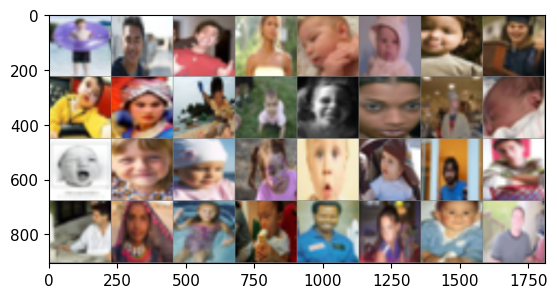

person person person person person person person person person person person person person person person person person person person person person person person person person person person person person person person person


In [ ]:
# Visualise the dataset
def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images, nrow=8))
classes = ['not person', 'person']

print(' '.join('%5s' % classes[1] for _ in labels))

# person_images = images[labels == 1]
# person_labels = labels[labels == 1]

# if len(person_images) > 0:
#     imshow(torchvision.utils.make_grid(person_images, nrow=8))
#     print(' '.join('%5s' % 'person' for _ in person_labels))
# else:
#     print("No 'person' images in this batch.")

In [ ]:
# Define the model - CvT
v = CvT(
    num_classes = 5,        # change the number of classes to 5
    s1_emb_dim = 64,        # stage 1 - dimension
    s1_emb_kernel = 7,      # stage 1 - conv kernel
    s1_emb_stride = 4,      # stage 1 - conv stride
    s1_proj_kernel = 3,     # stage 1 - attention ds-conv kernel size
    s1_kv_proj_stride = 2,  # stage 1 - attention key / value projection stride
    s1_heads = 1,           # stage 1 - heads
    s1_depth = 1,           # stage 1 - depth
    s1_mlp_mult = 4,        # stage 1 - feedforward expansion factor
    s2_emb_dim = 192,       # stage 2 - (same as above)
    s2_emb_kernel = 3,
    s2_emb_stride = 2,
    s2_proj_kernel = 3,
    s2_kv_proj_stride = 2,
    s2_heads = 3,
    s2_depth = 2,
    s2_mlp_mult = 4,
    s3_emb_dim = 384,       # stage 3 - (same as above)
    s3_emb_kernel = 3,
    s3_emb_stride = 2,
    s3_proj_kernel = 3,
    s3_kv_proj_stride = 2,
    s3_heads = 4,
    s3_depth = 10,
    s3_mlp_mult = 4,
    dropout = 0.
)

# v = SimpleViT(
#     image_size=256,
#     patch_size=32,
#     num_classes=5,  # Five output classes
#     dim=1024,
#     depth=6,
#     heads=16,
#     mlp_dim=2048
# )

# img = torch.randn(1, 3, 224, 224)
# pred = v(img) # (1, 1000)

PATH = "/content/drive/MyDrive/Computer Vision/Data/Classification/classification_people_CvT.pth"

In [ ]:
# Train the model
# Send the network to GPU memory
v.to(device)

# Initialise
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(v.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

iPrintEveryIteration = 100
iTotalEpochToTrain = 20
early_stopping = 5

original_indices = [2, 11, 35, 46, 98]
index_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(original_indices)}

# Function to apply mapping
def remap_labels(labels):
  return torch.tensor([index_mapping[label.item()] for label in labels], device=labels.device)

start_time = time.time()
best_val_loss = float('inf')
epochs_no_improve = 0

# Loop over the whole dataset
for epoch in range(iTotalEpochToTrain):
  v.train()
  running_loss = 0.0

  # Loop over each batch of training data
  for i, data in enumerate(trainloader, 0):

    inputs, labels = data[0].to(device), data[1].to(device)
    labels = remap_labels(labels)

    optimizer.zero_grad()

    # Do one forward, loss calculation and backward operation
    outputs = v(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # Print the loss every interval
    running_loss += loss.item()
    if i % iPrintEveryIteration == iPrintEveryIteration-1:
      print('[%d, %5d] loss: %.3f' %
          (epoch + 1, i + 1, running_loss / iPrintEveryIteration))
      running_loss = 0.0

  # Validation
  v.eval()
  val_loss = 0.0
  with torch.no_grad():
    for data in validloader:
      inputs, labels = data[0].to(device), data[1].to(device)
      labels = remap_labels(labels)

      outputs = v(inputs)
      batch_loss = criterion(outputs, labels)
      val_loss += batch_loss.item()

  val_loss /= len(validloader)
  print(f'Epoch {epoch + 1}: Validation Loss: {val_loss:.4f}')

  # Early stopping
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(v.state_dict(), PATH)
    epochs_no_improve = 0
  else:
    epochs_no_improve += 1
    if epochs_no_improve >= early_stopping:
      print(f"Early stopping after epoch {epoch + 1} ")
      break

  scheduler.step()

end_time = time.time()

print('Training completed!')
print(f"Training time: {(end_time - start_time):.2f} seconds")

# Save the trained network parameters into a file
PATH = "/content/drive/MyDrive/Computer Vision/Data/Classification/classification_people_CvT.pth"
torch.save(v.state_dict(), PATH)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1: Validation Loss: 1.6572
Epoch 2: Validation Loss: 1.5120
Epoch 3: Validation Loss: 1.4949
Epoch 4: Validation Loss: 1.4952
Epoch 5: Validation Loss: 1.4955
Epoch 6: Validation Loss: 1.4955
Epoch 7: Validation Loss: 1.4954
Epoch 8: Validation Loss: 1.4950
Early stopping after epoch 8 
Training completed!
Training time: 306.53 seconds


## 1.2.2 Run the Diversity Classification Model

In [ ]:
# The model
v = CvT(
    num_classes = 5,        # change the number of classes to 5
    s1_emb_dim = 64,        # stage 1 - dimension
    s1_emb_kernel = 7,      # stage 1 - conv kernel
    s1_emb_stride = 4,      # stage 1 - conv stride
    s1_proj_kernel = 3,     # stage 1 - attention ds-conv kernel size
    s1_kv_proj_stride = 2,  # stage 1 - attention key / value projection stride
    s1_heads = 1,           # stage 1 - heads
    s1_depth = 1,           # stage 1 - depth
    s1_mlp_mult = 4,        # stage 1 - feedforward expansion factor
    s2_emb_dim = 192,       # stage 2 - (same as above)
    s2_emb_kernel = 3,
    s2_emb_stride = 2,
    s2_proj_kernel = 3,
    s2_kv_proj_stride = 2,
    s2_heads = 3,
    s2_depth = 2,
    s2_mlp_mult = 4,
    s3_emb_dim = 384,       # stage 3 - (same as above)
    s3_emb_kernel = 3,
    s3_emb_stride = 2,
    s3_proj_kernel = 3,
    s3_kv_proj_stride = 2,
    s3_heads = 4,
    s3_depth = 10,
    s3_mlp_mult = 4,
    dropout = 0.
)

# v = SimpleViT(
#     image_size=256,
#     patch_size=32,
#     num_classes=5,  # Five output classes
#     dim=1024,
#     depth=6,
#     heads=16,
#     mlp_dim=2048
# )

# img = torch.randn(1, 3, 224, 224)
# pred = v(img) # (1, 1000)

PATH = "/content/drive/MyDrive/Computer Vision/Data/Classification/classification_people_CvT.pth"

# The transform
transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the state dictionary
v.load_state_dict(torch.load(PATH))
v.to(device)
v.eval()

CvT(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (1): LayerNorm()
      (2): Transformer(
        (layers): ModuleList(
          (0): ModuleList(
            (0): Attention(
              (norm): LayerNorm()
              (attend): Softmax(dim=-1)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_q): DepthWiseConv2d(
                (net): Sequential(
                  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                )
              )
              (to_kv): DepthWiseConv2d(
                (net): Sequential(
                  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
                  

In [ ]:
def remap_labels(labels):
    return torch.tensor([index_mapping[label.item()] for label in labels], device=labels.device)

# Store the correct predictions
original_indices = [2, 11, 35, 46, 98]
index_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(original_indices)}

class_correct = {i: 0 for i in index_mapping.values()}
class_total = {i: 0 for i in index_mapping.values()}

with torch.no_grad():
  # Iterate through the test set
  for data in testloader:
    inputs, labels = data[0].to(device), data[1].to(device)
    labels = remap_labels(labels)

    # Forward pass
    outputs = v(inputs)
    _, predicted = torch.max(outputs.data, 1)

    # Calculate per-class accuracy
    c = (predicted == labels).squeeze()
    for i in range(len(labels)):
      label = labels[i].item()
      class_correct[label] += c[i].item()
      class_total[label] += 1

# Print accuracy per class
for i in index_mapping.values():
  print('Accuracy of class %d : %.2f %%' % (
    i, 100 * class_correct[i] / class_total[i]))


Accuracy of class 0 : 35.00 %
Accuracy of class 1 : 15.00 %
Accuracy of class 2 : 19.00 %
Accuracy of class 3 : 49.00 %
Accuracy of class 4 : 25.00 %


In [ ]:
def apply_clahe(source_dirs, destination_dirs):
  # Define CLAHE
  def clahe(img_path, dest_path):
    img = cv2.imread(img_path)
    if img is not None:
      colour_img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
      l, a, b = cv2.split(colour_img)
      clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
      l2 = clahe.apply(l)
      colour_img = cv2.merge((l2, a, b))
      img_clahe = cv2.cvtColor(colour_img, cv2.COLOR_Lab2BGR)
      cv2.imwrite(dest_path, img_clahe)

    for source_dir, destination_dir in zip(source_dirs, destination_dirs):
      os.makedirs(destination_dir, exist_ok=True)
      for filename in os.listdir(source_dir):
        if filename.endswith('.jpg'):
          file_path = os.path.join(source_dir, filename)
          dest_path = os.path.join(destination_dir, filename)
          clahe(file_path, dest_path)
          print(f"Processed and saved: {dest_path}")

source_dirs = [
  "/content/drive/MyDrive/Computer Vision/Data/Patches/game",
  "/content/drive/MyDrive/Computer Vision/Data/Patches/movie"
]
destination_dirs = [
  "/content/drive/MyDrive/Computer Vision/Data/Classification/game",
  "/content/drive/MyDrive/Computer Vision/Data/Classification/movie"
]

# Apply CLAHE to all images
apply_clahe(source_dirs, destination_dirs)

In [ ]:
# # Use the mp4 dataset to classify the frames
# train_dir = "/content/drive/MyDrive/Computer Vision/Data/Train"

# mp4_files = []

# # Find the mp4 files
# for path, folders, files in os.walk(train_dir):
#   for filename in [f for f in files if f.endswith(".mp4")]:
#     mp4_files.append(os.path.join(path, filename))

# def process_video_frames(video_path, interval=2):
#   cap = cv2.VideoCapture(video_path)
#   frame_count = 0
#   processed_frames = 0
#   total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#   print(f"Total frames in {video_path}: {total_frames}")

#   while True:
#     ret, frame = cap.read()
#     if not ret:
#       print(f"Failed to read frame at count {frame_count}")
#       break

#     if frame_count % interval == 0:
#       print(f"Processing frame {frame_count}")
#       frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#       pil_image = Image.fromarray(frame)
#       transformed_frame = transform(pil_image).unsqueeze(0).to(device)

#       # Prediction
#       output = v(transformed_frame)
#       _, predicted = torch.max(output, 1)

#       print(f"Predicted class for frame {frame_count}: {predicted.item()}")

#       # Check if the predicted class is a person
#       if predicted.item() == 1:
#         print(f"Human detected in frame {frame_count}")
#         frame_filename = f"{video_path}_frame_{frame_count}_person.jpg"
#         cv2.imwrite(frame_filename, frame)
#         processed_frames += 1

#     frame_count += 1

#   cap.release()

# for video_file in mp4_files:
#   process_video_frames(video_file, 2)

In [ ]:
# Extract the frames at certain intervals (for a variety of frames)
# Exact the images with humans (any of the baby, boy, girl, man, woman classes)
from PIL import Image
from collections import defaultdict

def label_to_classname(label):
  classes = {0: 'baby', 1: 'boy', 2: 'girl', 3: 'man', 4: 'woman'}
  return classes.get(label, "unknown")

def classify_and_count_images(dirs, model, device, transform):
  category_counts = {dir_path: defaultdict(int) for dir_path in dirs}

  for dir_path in dirs:
    image_files = [f for f in os.listdir(dir_path) if f.endswith('.jpg')]

    for img_file in image_files:
      img_path = os.path.join(dir_path, img_file)
      image = Image.open(img_path)
      image = image.convert('RGB')

      # Apply transformation and predict
      transformed_image = transform(image).unsqueeze(0).to(device)
      output = model(transformed_image)
      _, predicted = torch.max(output, 1)
      prediction_class = label_to_classname(predicted.item())

      # Update count
      category_counts[dir_path][prediction_class] += 1

  return category_counts

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dirs = [
    "/content/drive/MyDrive/Computer Vision/Data/Classification/game",
    "/content/drive/MyDrive/Computer Vision/Data/Classification/movie"
]

category_counts = classify_and_count_images(dirs, v, device, transform)
for dir_path, counts in category_counts.items():
  print(f"{dir_path}:")
  for category, count in counts.items():
    print(f"{category}: {count}")


/content/drive/MyDrive/Computer Vision/Data/Classification/game:
baby: 546
/content/drive/MyDrive/Computer Vision/Data/Classification/movie:
baby: 213


In [ ]:
# Save 50 images in another folder
source_dirs = [
  "/content/drive/MyDrive/Computer Vision/Data/Classification/game",
  "/content/drive/MyDrive/Computer Vision/Data/Classification/movie"
]
destination_dir = "/content/drive/MyDrive/Computer Vision/Data/Submit/ImprovedSelection"

os.makedirs(destination_dir, exist_ok=True)

jpg_files = []
for dir_path in source_dirs:
  files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith('.jpg')]
  jpg_files.extend(files)

if len(jpg_files) >= 50:
  selected_files = random.sample(jpg_files, 50)
else:
  selected_files = jpg_files

for file_path in selected_files:
  shutil.copy(file_path, destination_dir)


## 2.1.1 Train Style Transfer Model (Frames and CycleGAN)

In [ ]:
# Extract original unseen frames and test the style transfer on these
game_dir = "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer/trainA"
movie_dir = "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer/trainB"

os.makedirs(game_dir, exist_ok=True)
os.makedirs(movie_dir, exist_ok=True)

# Save frames every 500 intervals
interval = 500

# Loop through each mp4 training file
for video_file in mp4_files:
  cap = cv2.VideoCapture(video_file)
  frame_count = 0

  while True:
    ret, frame = cap.read()
    if not ret:
      break

    category = "game" if "game" in video_file else "movie"

    # Extract the frames at certain intervals
    if frame_count % interval == 0:
      if category == "game":
        frame_filename = os.path.join(game_dir, f"{frame_count}.jpg")
      else:
        frame_filename = os.path.join(movie_dir, f"{frame_count}.jpg")
      cv2.imwrite(frame_filename, frame)
      print(f"Saved: {frame_filename}")

    frame_count += 1

  cap.release()
  print(f"Finished processing {video_file}")

Saved: /content/drive/MyDrive/Computer Vision/Data/StyleTransfer/trainA/0.jpg
Saved: /content/drive/MyDrive/Computer Vision/Data/StyleTransfer/trainA/500.jpg
Saved: /content/drive/MyDrive/Computer Vision/Data/StyleTransfer/trainA/1000.jpg
Saved: /content/drive/MyDrive/Computer Vision/Data/StyleTransfer/trainA/1500.jpg
Saved: /content/drive/MyDrive/Computer Vision/Data/StyleTransfer/trainA/2000.jpg
Saved: /content/drive/MyDrive/Computer Vision/Data/StyleTransfer/trainA/2500.jpg
Saved: /content/drive/MyDrive/Computer Vision/Data/StyleTransfer/trainA/3000.jpg
Saved: /content/drive/MyDrive/Computer Vision/Data/StyleTransfer/trainA/3500.jpg
Saved: /content/drive/MyDrive/Computer Vision/Data/StyleTransfer/trainA/4000.jpg
Saved: /content/drive/MyDrive/Computer Vision/Data/StyleTransfer/trainA/4500.jpg
Saved: /content/drive/MyDrive/Computer Vision/Data/StyleTransfer/trainA/5000.jpg
Saved: /content/drive/MyDrive/Computer Vision/Data/StyleTransfer/trainA/5500.jpg
Saved: /content/drive/MyDrive/Co

In [ ]:
# Define the test set
# Destination directories for test set
test_game_dir = "/content/drive/MyDrive/Computer Vision/StyleTransfer/testA"
test_movie_dir = "/content/drive/MyDrive/Computer Vision/StyleTransfer/testB"

test_proportion = 0.2

os.makedirs(test_game_dir, exist_ok=True)
os.makedirs(test_movie_dir, exist_ok=True)

# Move files to the test set
def move_files_to_test(source_dir, test_dir, proportion):
  files = os.listdir(source_dir)
  num_files_to_move = int(len(files) * proportion)
  files_to_move = random.sample(files, num_files_to_move)
  for file in files_to_move:
    source_file = os.path.join(source_dir, file)
    dest_file = os.path.join(test_dir, file)
    shutil.move(source_file, dest_file)

move_files_to_test(game_dir, test_game_dir, test_proportion)
move_files_to_test(movie_dir, test_movie_dir, test_proportion)

In [ ]:
# Clone CycleGAN
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git
%cd pytorch-CycleGAN-and-pix2pix
!pip install -r requirements.txt -q

# Copy the dataset and place inside the cloned datasets directory
source_dir = "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer"
destination_dir = "/content/pytorch-CycleGAN-and-pix2pix/datasets/StyleTransfer"
shutil.copytree(source_dir, destination_dir)

In [ ]:
# Train the CycleGAN
# %load_ext tensorboard
# %tensorboard --logdir /content/logs
torch.multiprocessing.set_start_method('spawn', force=True)
!python train.py --dataroot /content/pytorch-CycleGAN-and-pix2pix/datasets/StyleTransfer --name game-movie-transfer --model cycle_gan --n_epochs 12 --n_epochs_decay 4 --batch_size 2

----------------- Options ---------------
               batch_size: 2                             	[default: 1]
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: /content/pytorch-CycleGAN-and-pix2pix/datasets/StyleTransfer	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: la

In [ ]:
source_dir = "/content/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer"
destination_dir = "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer/weights"
shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)

'/content/drive/MyDrive/Computer Vision/Data/StyleTransfer/weights'

## 2.1.2 Evaluate the CycleGAN Model

In [ ]:
# !ls "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer/weights"
# df = pd.read_csv("/content/drive/MyDrive/Computer Vision/Data/StyleTransfer/loss_log.txt")
# plt.figure(figsize=(10, 5))
# plt.plot(df['epoch'], df['D_A_loss'], label='D_A Loss')
# plt.plot(df['epoch'], df['D_B_loss'], label='D_B Loss')
# plt.plot(df['epoch'], df['G_A_loss'], label='G_A Loss')
# plt.plot(df['epoch'], df['G_B_loss'], label='G_B Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Losses Over Epochs')
# plt.legend()
# plt.show()

10_net_D_A.pth	15_net_D_A.pth	5_net_D_A.pth  latest_net_D_A.pth  loss_log.txt
10_net_D_B.pth	15_net_D_B.pth	5_net_D_B.pth  latest_net_D_B.pth  train_opt.txt
10_net_G_A.pth	15_net_G_A.pth	5_net_G_A.pth  latest_net_G_A.pth  web
10_net_G_B.pth	15_net_G_B.pth	5_net_G_B.pth  latest_net_G_B.pth


In [ ]:
# source_dir = "/content/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer"
# destination_dir = "/content/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer"
# shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)

In [ ]:
# Test the model on the frames in the forward direction
os.rename("/content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer/latest_net_G_A.pth", "/content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer/latest_net_G.pth")
shutil.rmtree("/content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer/test_latest")
!python test.py --dataroot /content/pytorch-CycleGAN-and-pix2pix/datasets/StyleTransfer/testA --name /content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer --model test --no_dropout --results_dir /content/drive/MyDrive/Computer\ Vision/Data/StyleTransfer/forwards
os.rename("/content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer/latest_net_G.pth", "/content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer/latest_net_G_A.pth")

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/pytorch-CycleGAN-and-pix2pix/datasets/StyleTransfer/testA	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load

In [ ]:
source_dir = "/content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer/test_latest"
destination_dir = "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer/forwards"
shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)

'/content/drive/MyDrive/Computer Vision/Data/StyleTransfer/forwards'

In [ ]:
# Test the models on the frames in the backwards direction
os.rename("/content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer/latest_net_G_B.pth", "/content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer/latest_net_G.pth")
shutil.rmtree("/content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer/test_latest")
!python test.py --dataroot /content/pytorch-CycleGAN-and-pix2pix/datasets/StyleTransfer/testB --name /content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer --model test --no_dropout --results_dir /content/drive/MyDrive/Computer\ Vision/Data/StyleTransfer/forwards
os.rename("/content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer/latest_net_G.pth", "/content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer/latest_net_G_B.pth")

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/pytorch-CycleGAN-and-pix2pix/datasets/StyleTransfer/testB	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load

In [ ]:
source_dir = "/content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer/test_latest"
destination_dir = "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer/backwards"
shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)

'/content/drive/MyDrive/Computer Vision/Data/StyleTransfer/backwards'

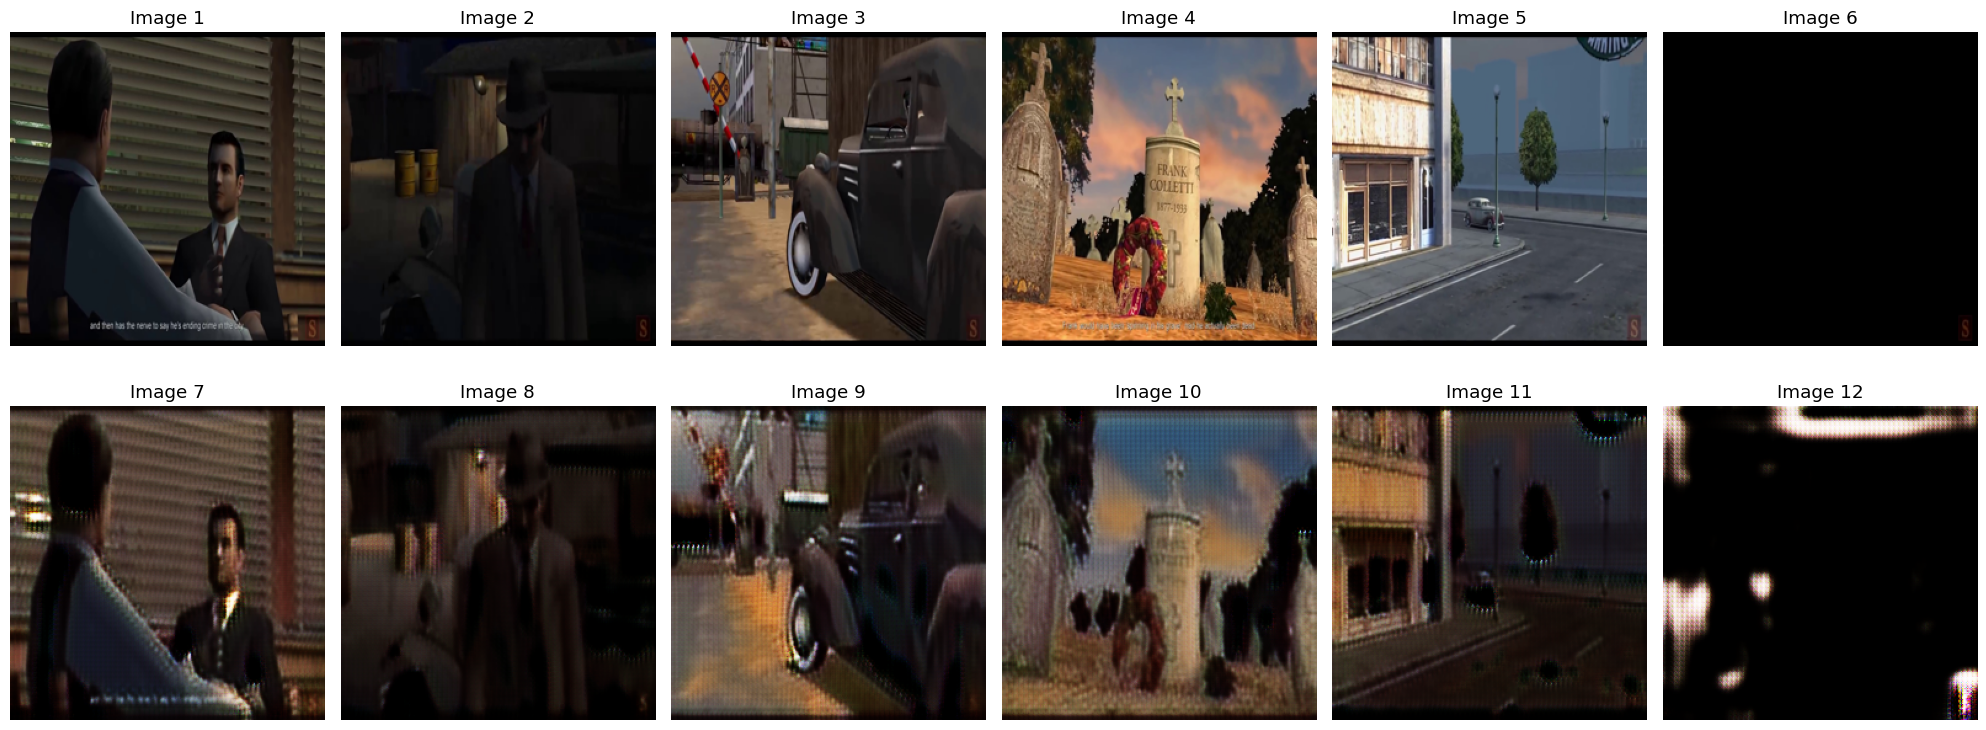

In [ ]:
# Visualise the results for forwards
import matplotlib.pyplot as plt
%matplotlib inline
def visualize_images(base_dir, image_names):
  nrows, ncols = 2, 6
  fig, axs = plt.subplots(nrows, ncols, figsize=(20, 8))

  for i, image_name in enumerate(image_names):
    img_path = os.path.join(base_dir, f"{image_name}.png")

    # Load and display the image
    img = plt.imread(img_path)
    ax = axs[i // ncols, i % ncols]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Image {i+1}')

  plt.tight_layout()
  plt.show()

base_dir = '/content/drive/MyDrive/Computer Vision/Data/StyleTransfer/forwards/images'

image_names = [
  '203000_real', '105000_real', '188500_real', '132000_real', '143000_real', '179000_real',
  '203000_fake', '105000_fake', '188500_fake', '132000_fake', '143000_fake', '179000_fake'
]

visualize_images(base_dir, image_names)

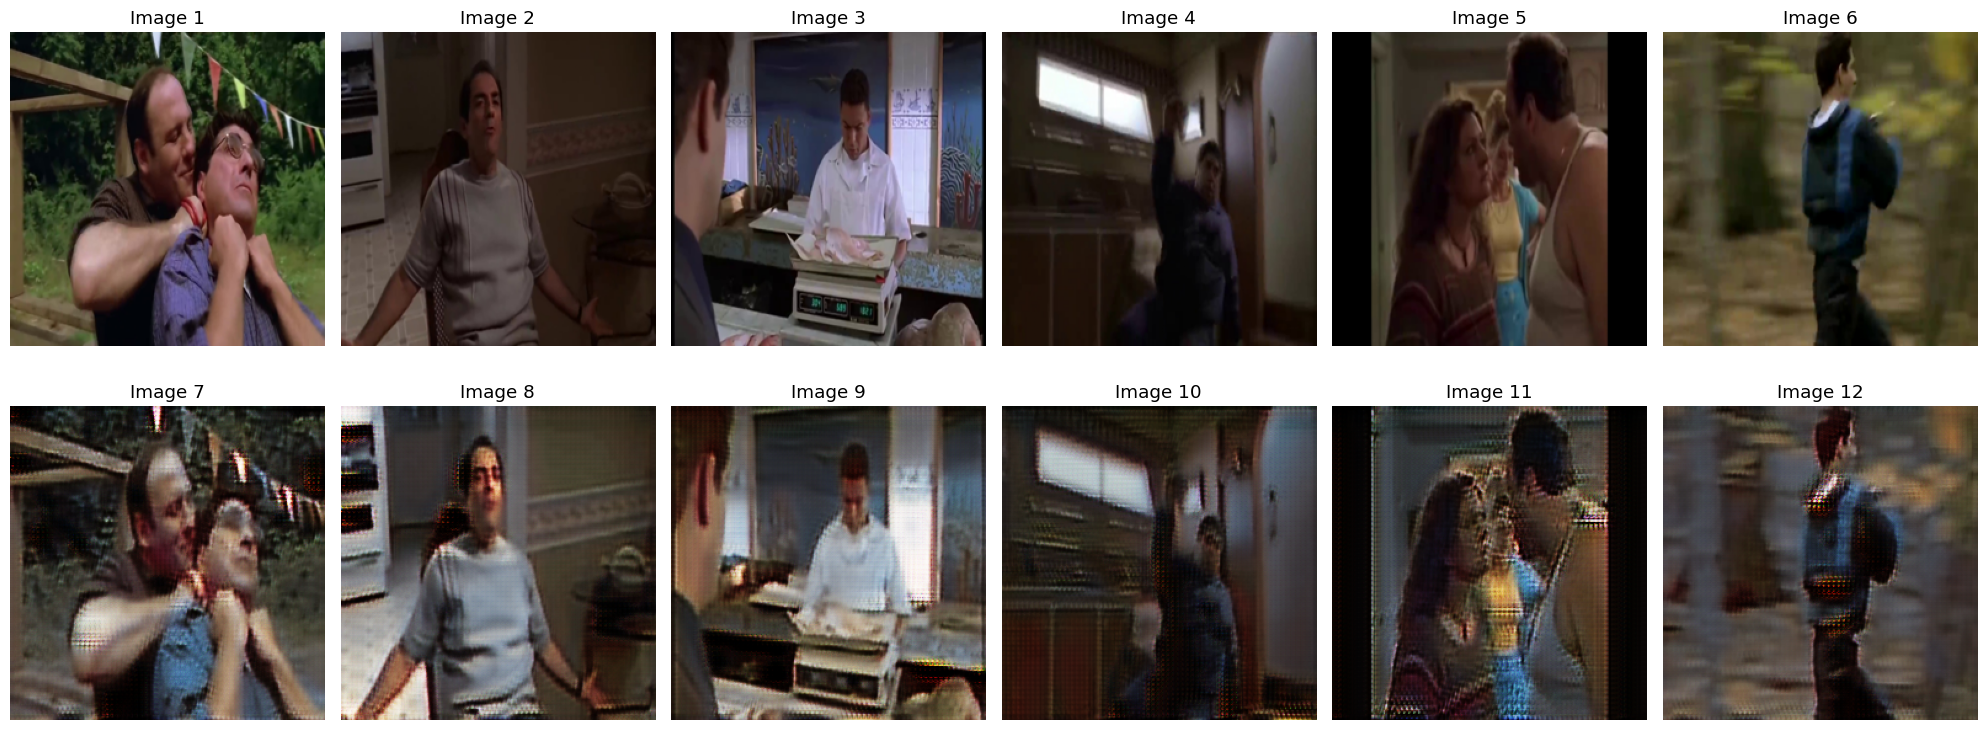

In [ ]:
# Visualise for backwards
base_dir = '/content/drive/MyDrive/Computer Vision/Data/StyleTransfer/backwards/images'

# Manually input the image names here; for example:
image_names = [
  '41500_real', '25000_real', '6500_real', '3500_real', '15000_real', '44500_real',
  '41500_fake', '25000_fake', '6500_fake', '3500_fake', '15000_fake', '44500_fake'
]

# Call the function to visualize the images
visualize_images(base_dir, image_names)

In [ ]:
# Perform evaluation with LPIPS
lpips_model = lpips.LPIPS(net='vgg').to('cuda')

def batch_lpips(directory):
  transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
  ])

  distances = []
  images_info = []

  for filename in os.listdir(directory):
    if filename.endswith("_real.png"):
      real_path = os.path.join(directory, filename)
      fake_filename = filename.replace("_real.png", "_fake.png")
      fake_path = os.path.join(directory, fake_filename)

      if os.path.exists(fake_path):
        img1 = transform(Image.open(real_path)).unsqueeze(0).to('cuda')
        img2 = transform(Image.open(fake_path)).unsqueeze(0).to('cuda')

        # Compute LPIPS distance
        with torch.no_grad():
          distance = lpips_model(img1, img2).item()

        distances.append(distance)
        images_info.append((distance, real_path, fake_path))

  # Calculate average distance
  average_distance = sum(distances) / len(distances)

  # Sort to find the best and worst
  images_info.sort()
  best_10 = images_info[:5]
  worst_10 = images_info[-5:]

  return average_distance, best_10, worst_10

directory = '/content/drive/MyDrive/Computer Vision/Data/StyleTransfer/backwards/images'

average_distance, best_10, worst_10 = batch_lpips(directory)

print('Average LPIPS Distance:', average_distance)
print('Best 10 Pairs:', best_10)
print('Worst 10 Pairs:', worst_10)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth
Average LPIPS Distance: 0.3976703107357025
Best 10 Pairs: [(0.32620668411254883, '/content/drive/MyDrive/Computer Vision/Data/StyleTransfer/backwards/images/20500_real.png', '/content/drive/MyDrive/Computer Vision/Data/StyleTransfer/backwards/images/20500_fake.png'), (0.33106717467308044, '/content/drive/MyDrive/Computer Vision/Data/StyleTransfer/backwards/images/51000_real.png', '/content/drive/MyDrive/Computer Vision/Data/StyleTransfer/backwards/images/51000_fake.png'), (0.3439484238624573, '/content/drive/MyDrive/Computer Vision/Data/StyleTransfer/backwards/images/26000_real.png', '/content/drive/MyDrive/Computer Vision/Data/StyleTransfer/backwards/images/26000_fake.png'), (0.3522084951400757, '/content/drive/MyDrive/Computer Vision/Data/StyleTransfer/backwards/images/25000_real.png', '/content/drive/MyDrive/Computer Vision/Dat

## 2.2.1 Create Style Transfer Video

In [ ]:
# Run the previous model on the video test set and save the result
# test.py is the standard to generate all the images

video_file = "/content/drive/MyDrive/Computer Vision/Data/Test/Test.mp4"
category_dir = "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer2/frames"
os.makedirs(category_dir, exist_ok=True)

# audio_file = "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer2/audio.mp3"

# Extract the audio
clip = VideoFileClip(video_file)
# clip.audio.write_audiofile(audio_file)

cap = cv2.VideoCapture(video_file)
frame_count = 0

fps = cap.get(cv2.CAP_PROP_FPS)

while True:
  ret, frame = cap.read()
  if not ret:
    break

  if frame_count == 0:
    height, width, layers = frame.shape

  frame_filename = os.path.join(category_dir, f"{frame_count}.jpg")
  cv2.imwrite(frame_filename, frame)
  print(f"Saved: {frame_filename}")

  frame_count += 1

cap.release()
print(f"Finished processing {video_file}")

source_dir = "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer2/frames"
destination_dir = "/content/pytorch-CycleGAN-and-pix2pix/datasets/convert/testA"
shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)

In [ ]:
# Test the model on the frames
os.rename("/content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer/latest_net_G_A.pth", "/content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer/latest_net_G.pth")
shutil.rmtree("/content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer/test_latest")
!python test.py --dataroot /content/pytorch-CycleGAN-and-pix2pix/datasets/convert/testA --name /content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer --model test --no_dropout --results_dir /content/drive/MyDrive/Computer\ Vision/Data/StyleTransfer2/results --num_test 10000
os.rename("/content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer/latest_net_G.pth", "/content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer/latest_net_G_A.pth")

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/pytorch-CycleGAN-and-pix2pix/datasets/convert/testA	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter:

In [ ]:
source_dir = "/content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer/test_latest"
destination_dir = "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer2/results"
shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)

'/content/drive/MyDrive/Computer Vision/Data/StyleTransfer2/results'

In [ ]:
# Convert the frames back to video, with the correct frame rate and size
def frames_to_video(frames_dir, output_video_file, fps):
  # Determine the dimensions from the specified directory
  dimension_frame_dir = "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer2/frames"
  dimension_frame_file = os.listdir(dimension_frame_dir)[0]  # Assuming there is at least one image
  dimension_frame_path = os.path.join(dimension_frame_dir, dimension_frame_file)
  dimension_frame = cv2.imread(dimension_frame_path)

  if dimension_frame is None:
      print(f"Failed to load the dimension frame: {dimension_frame_path}")
      return

  height, width, layers = dimension_frame.shape

  # Only include the _fake files
  frame_files = [os.path.join(frames_dir, f) for f in os.listdir(frames_dir) if f.endswith('_fake.png')]
  frame_files = natsorted(frame_files)

  # Load the first frame
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  video = cv2.VideoWriter(output_video_file, fourcc, fps, (width, height))

  # Loop through the rest of the frames
  for frame_file in frame_files:
    frame = cv2.imread(frame_file)
    if frame is not None:
      frame = cv2.resize(frame, resize_dim, interpolation=cv2.INTER_AREA)
      video.write(frame)
    else:
      print(f"Failed to load image {frame_file}")

  video.release()
  print(f"Video written to {output_video_file}")

# Call the function with the updated settings
frames_dir = "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer2/results/images"
output_video_file = "/content/drive/MyDrive/Computer Vision/Data/Submit/Videos/result.mp4"
frames_to_video(frames_dir, output_video_file, fps)

Video written to /content/drive/MyDrive/Computer Vision/Data/Submit/Videos/result.mp4


## 2.2.2 Improved Style Transfer

In [ ]:
from PIL import Image
# Create a second style transfer focussing on the people in frames
# Resize the patch images and add to a new folder
def resize_images(folder_path, style_transfer_path):
  size=(256, 256)

  os.makedirs(style_transfer_path, exist_ok=True)

  for filename in os.listdir(folder_path):
    if filename.endswith('.jpg'):
      image_path = os.path.join(folder_path, filename)
      with Image.open(image_path) as img:
        img = img.resize(size, Image.ANTIALIAS)
        # Save the resized image in the new folder
        resized_image_path = os.path.join(style_transfer_path, filename)
        img.save(resized_image_path)

resize_images("/content/drive/MyDrive/Computer Vision/Data/Patches/game", "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer2/trainA")
resize_images("/content/drive/MyDrive/Computer Vision/Data/Patches/movie", "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer2/trainB")

source_dir = "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer2"
#shutil.rmtree("/content/pytorch-CycleGAN-and-pix2pix/datasets/StyleTransfer2")
destination_dir = "/content/pytorch-CycleGAN-and-pix2pix/datasets/StyleTransfer2"
shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)

  img = img.resize(size, Image.ANTIALIAS)



'/content/pytorch-CycleGAN-and-pix2pix/datasets/StyleTransfer2'

In [ ]:
# Train a second style transfer with the patches and a human dataset
torch.multiprocessing.set_start_method('spawn', force=True)
!python train.py --dataroot /content/pytorch-CycleGAN-and-pix2pix/datasets/StyleTransfer2 --name game-movie-transfer-people --model cycle_gan --n_epochs 12 --n_epochs_decay 4 --batch_size 2

----------------- Options ---------------
               batch_size: 2                             	[default: 1]
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: /content/pytorch-CycleGAN-and-pix2pix/datasets/StyleTransfer2	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: l

In [ ]:
# Detect people within each frame
def detect_people(frame, W, H):
  people = []
  model_path = "/content/drive/MyDrive/Computer Vision/Data/Detection/weights/gelan-c.pt"
  conf = 0.5

  frame_path = "/tmp/frame.jpg"
  cv2.imwrite(frame_path, frame)

  output_dir = "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer2/runs/detect"
  output_name = "static_exp"

  # Run the model to make the detection prediction
  command = f"python yolov9/detect.py --weights \"{model_path}\" --conf-thres {conf} --source \"{frame_path}\" --device 0 --save-txt --save-conf --project \"{output_dir}\" --name \"{output_name}\" --exist-ok"

  # Delete existing labels within our folder for the previous frame
  list_of_dirs = glob.glob(f'{output_dir}/{output_name}*')
  if list_of_dirs:
    latest_dir = max(list_of_dirs, key=os.path.getctime)
    label_file = os.path.join(latest_dir, 'labels', os.path.basename(frame_path).replace('.jpg', '.txt'))
    if os.path.exists(label_file):
      os.remove(label_file)
      print(f"Deleted existing label file: {label_file}")

  process = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
  if process.returncode != 0:
    print("Error:", process.stderr)
    return []

  # Check the directory for the txt file
  list_of_dirs = glob.glob(f'{output_dir}/{output_name}*')
  latest_dir = max(list_of_dirs, key=os.path.getctime)
  label_file = os.path.join(latest_dir, 'labels', os.path.basename(frame_path).replace('.jpg', '.txt'))

  # Read the txt file correctly
  if os.path.exists(label_file):
    with open(label_file, 'r') as file:
      lines = file.readlines()
      for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        # Extract the patches
        # Make sure these are the best (above 82% confidence)
        if class_id == 0 and float(parts[5]) >= 0.95:
          x_center = float(parts[1]) * W
          y_center = float(parts[2]) * H
          width = float(parts[3]) * W
          height = float(parts[4]) * H
          x1 = int(x_center - (width / 2))
          y1 = int(y_center - (height / 2))
          x2 = int(x_center + (width / 2))
          y2 = int(y_center + (height / 2))
          people.append((x1, y1, x2, y2))
  else:
    print("Detection results file not found:", label_file)

  # print(people)

  return people


images_dir = "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer2/frames"
patch_dir = "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer2/patches"
csv_path = os.path.join(patch_dir, "detections.csv")

os.makedirs(patch_dir, exist_ok=True)

with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Image Name", "Patch Filename", "X1", "Y1", "X2", "Y2"])

image_counter = 0

# Loop through each image
for image_name in os.listdir(images_dir):
    image_path = os.path.join(images_dir, image_name)
    frame = cv2.imread(image_path)

    if frame is not None:
        H, W = frame.shape[:2]
        detections = detect_people(frame, W, H)

        for (x1, y1, x2, y2) in detections:
            x1, y1, x2, y2 = max(0, x1), max(0, y1), min(W, x2), min(H, y2)
            human_patch = frame[y1:y2, x1:x2]
            patch_filename = os.path.join(patch_dir, f"{image_counter}.jpg")
            cv2.imwrite(patch_filename, human_patch)

            with open(csv_path, mode='a', newline='') as file:
              writer = csv.writer(file)
              writer.writerow([image_name, patch_filename, x1, y1, x2, y2])

            image_counter += 1


In [ ]:
# source_dir = "/content/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer-people"
# destination_dir = "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer2/weights"
# shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)

# source_dir = "/content/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer-people"
# destination_dir = "/content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer-people"
# shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)

# source_dir = "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer2/frames"
# destination_dir = "/content/pytorch-CycleGAN-and-pix2pix/datasets/convert_final/testA"
# shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)

'/content/pytorch-CycleGAN-and-pix2pix/datasets/convert_final/testA'

In [ ]:
# Run the new style transfer model on the frames
#os.rename("/content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer-people/latest_net_G_A.pth", "/content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer-people/latest_net_G.pth")
#shutil.rmtree("/content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer-people/test_latest")
!python test.py --dataroot /content/pytorch-CycleGAN-and-pix2pix/datasets/convert_final/testA --name /content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer-people --model test --no_dropout --results_dir /content/drive/MyDrive/Computer\ Vision/Data/StyleTransfer2/results2 --num_test 10000
os.rename("/content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer-people/latest_net_G.pth", "/content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer-people/latest_net_G_A.pth")

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/pytorch-CycleGAN-and-pix2pix/datasets/convert_final/testA	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load

In [ ]:
source_dir = "/content/pytorch-CycleGAN-and-pix2pix/checkpoints/game-movie-transfer/test_latest"
destination_dir = "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer2/results2"
shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)

'/content/drive/MyDrive/Computer Vision/Data/StyleTransfer2/results2'

In [ ]:
# Read the csv previosuly created
def read_csv_data(csv_path):
  data = {}
  with open(csv_path, mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header row
    for row in reader:
      image_name, patch_filename, x1, y1, x2, y2 = row
      frame_index = int(image_name.split('_')[-1].split('.')[0])
      if frame_index not in data:
        data[frame_index] = []
      data[frame_index].append((patch_filename, int(x1), int(y1), int(x2), int(y2)))
  return data

def overlay_patches_to_video(frames_dir, patches_info, output_video_file, fps):
  frame_files = [os.path.join(frames_dir, f) for f in os.listdir(frames_dir)]
  frame_files = natsorted(frame_files)

  first_frame = cv2.imread(frame_files[0])
  height, width, layers = first_frame.shape
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  video = cv2.VideoWriter(output_video_file, fourcc, fps, (width, height))

  for i, frame_file in enumerate(frame_files):
    frame = cv2.imread(frame_file)
    if frame is not None:
      if i in patches_info:
        for patch_detail in patches_info[i]:
          patch_filename, x1, y1, x2, y2 = patch_detail
          patch_img = cv2.imread(patch_filename)
          if patch_img is not None:
            patch_img = cv2.resize(patch_img, ((x2 - x1), (y2 - y1)))
            frame[y1:y2, x1:x2] = patch_img
      video.write(frame)

  video.release()

frames_dir = "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer2/results2/images"
patch_dir = "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer2/patches"
csv_path = os.path.join(patch_dir, "detections.csv")
output_video_file = "/content/drive/MyDrive/Computer Vision/Data/Submit/Videos/result_improved.mp4"
fps = 30

patches_info = read_csv_data(csv_path)

overlay_patches_to_video(frames_dir, patches_info, output_video_file, fps)

In [ ]:
# Convert the frames back to video, with the correct frame rate and size
def frames_to_video(frames_dir, output_video_file, fps):
  # Only include the _fake files
  frame_files = [os.path.join(frames_dir, f) for f in os.listdir(frames_dir) if f.endswith('_fake.png')]
  frame_files = natsorted(frame_files)

  # Determine the dimensions from the specified directory
  dimension_frame_dir = "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer2/frames"
  dimension_frame_file = os.listdir(dimension_frame_dir)[0]  # Assuming there is at least one image
  dimension_frame_path = os.path.join(dimension_frame_dir, dimension_frame_file)
  dimension_frame = cv2.imread(dimension_frame_path)
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  video = cv2.VideoWriter(output_video_file, fourcc, fps, (width, height))

  # Loop through the rest of the frames
  for frame_file in frame_files:
    frame = cv2.imread(frame_file)
    if frame is not None:
      frame = cv2.resize(frame, resize_dim, interpolation=cv2.INTER_AREA)
      video.write(frame)
    else:
      print(f"Failed to load image {frame_file}")

  video.release()
  print(f"Video written to {output_video_file}")

# Call the function with the updated settings
resize_dim = (width, height)
frames_dir = "/content/drive/MyDrive/Computer Vision/Data/StyleTransfer2/results2/images"
output_video_file = "/content/drive/MyDrive/Computer Vision/Data/Submit/Videos/result_final.mp4"
frames_to_video(frames_dir, output_video_file, fps)

Video written to /content/drive/MyDrive/Computer Vision/Data/Submit/Videos/result_final.mp4


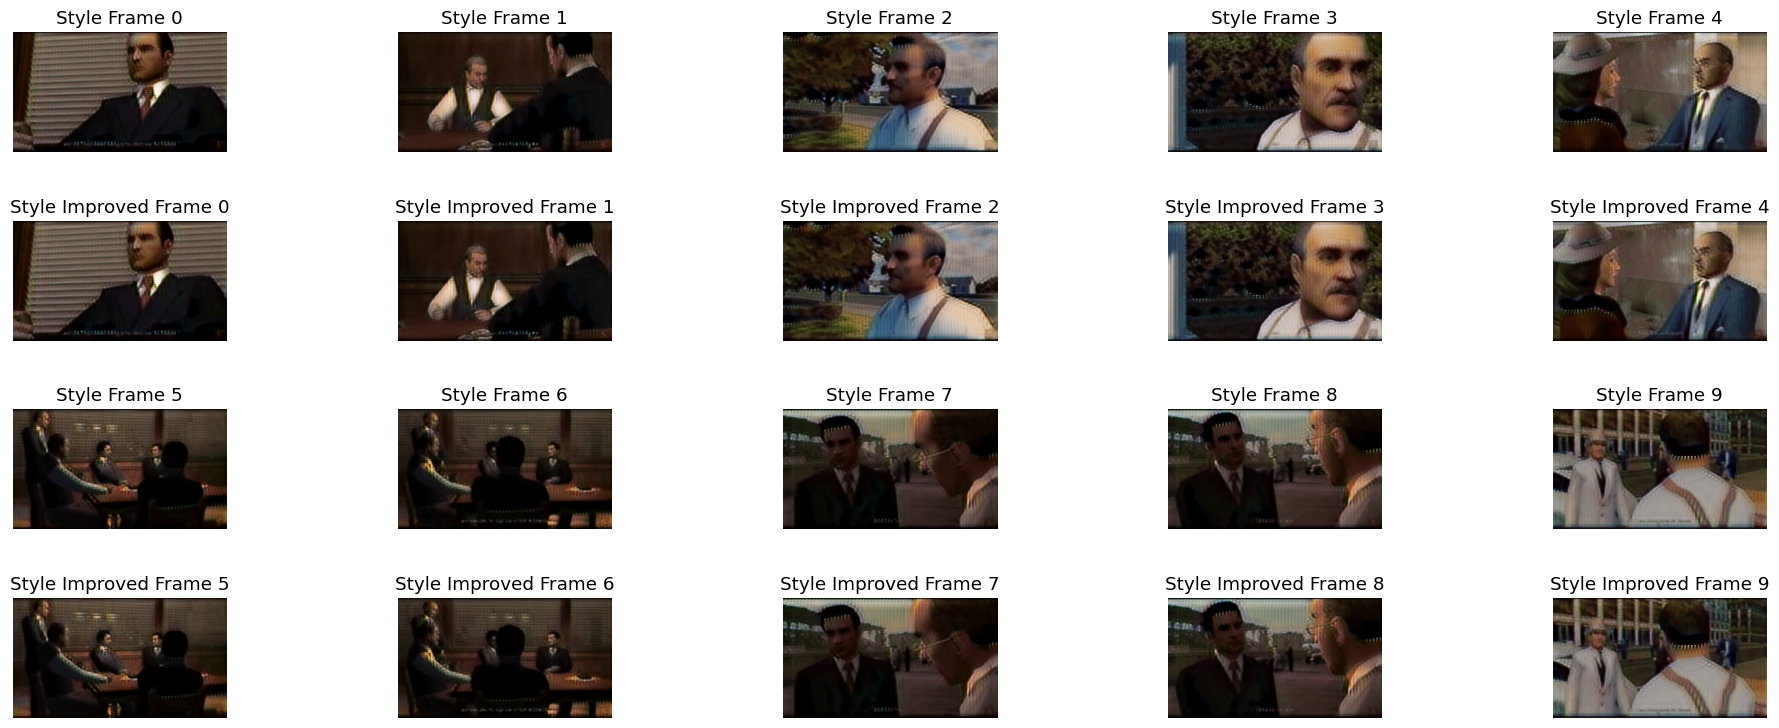

In [ ]:
# Display frames for comparison from the videos
def extract_frame(video_path, frame_index):
  cap = cv2.VideoCapture(video_path)
  cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
  ret, frame = cap.read()
  if ret:
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  else:
      frame = None
  cap.release()
  return frame

def display_frames(v1_frames, v2_frames):
  cols = 5
  rows = 4

  plt.figure(figsize=(20, 8))

  for i in range(10):
      row = (i // cols) * 2

      plt.subplot(rows, cols, 1 + i % cols + row * cols)
      plt.imshow(v1_frames[i])
      plt.title(f"Style Frame {i}")
      plt.axis('off')

      plt.subplot(rows, cols, 1 + i % cols + (row + 1) * cols)
      plt.imshow(v2_frames[i])
      plt.title(f"Style Improved Frame {i}")
      plt.axis('off')

  plt.tight_layout(pad=3.0)
  plt.show()

video1_path = "/content/drive/MyDrive/Computer Vision/Data/Submit/Videos/result.mp4"
video2_path = "/content/drive/MyDrive/Computer Vision/Data/Submit/Videos/result_final.mp4"

total_frames = min(int(cv2.VideoCapture(video1_path).get(cv2.CAP_PROP_FRAME_COUNT)),
                   int(cv2.VideoCapture(video2_path).get(cv2.CAP_PROP_FRAME_COUNT)))

random_frame_indices = sorted(random.sample(range(total_frames), 10))

v1_random_frames = [extract_frame(video1_path, idx) for idx in random_frame_indices]
v2_random_frames = [extract_frame(video2_path, idx) for idx in random_frame_indices]

display_frames(v1_random_frames, v2_random_frames)